# Lane Switch Agents

## Rule-Based Agent

In [3]:
import sys
sys.path.append('../src')

import matplotlib.pyplot as plt

from environment import TrafficEnvironment

### Agent Implementation

In [6]:
class RuleBasedAgent:
    def __init__(self, environment):
        self.env = environment
    
    def choose_action(self):
        """
        Chooses an action based on the current clearance rates of the lanes.
        - If the current lane is performing well, the agent stays.
        - If a neighboring lane performs better, the agent tries to switch.
        """
        current_lane = self.env.current_lane
        current_clearance_rate = self.env.clearance_rates[current_lane - 1]

        # Check neighboring lanes
        left_lane = current_lane - 1 if current_lane > 1 else None
        right_lane = current_lane + 1 if current_lane < self.env.lanes else None
        
        # Compare clearance rates
        if left_lane is not None and self.env.clearance_rates[left_lane - 1] > current_clearance_rate:
            # Prefer moving left if the left lane has a higher clearance rate
            return -1  # Move left
        elif right_lane is not None and self.env.clearance_rates[right_lane - 1] > current_clearance_rate:
            # Move right if the right lane has a higher clearance rate
            return 1  # Move right
        else:
            # Stay in the current lane if it has the best or comparable clearance rate
            return 0  # Stay

### Testing

In [7]:
env = TrafficEnvironment()
state = env.reset()
done = False
rewards = []  # To track rewards at each time step
time_steps = []  # To track the time step number

# Create an instance of the RuleBasedAgent
agent = RuleBasedAgent(env)

time_step_counter = 0

while not done:
    # Randomly choose an action (-1: move left, 0: stay, 1: move right)
    action = agent.choose_action()

    # Take the step
    next_state, reward, done = env.step(action)

    # Append the reward for this time step
    rewards.append(reward)
    time_steps.append(time_step_counter)

    # Increment the time step counter
    time_step_counter += 1

    print(f"Action: {action}, Reward: {reward}, Done: {done}")
    print(f"Next State: {next_state}")

Initial Distance:  4000
Initial Clearance Rates:  [17.8 16.6 19.7 18.3 18.3]
Initial Lane:  1
Action: 0, Reward: 7.4, Done: False
Next State: [(4000, 1, np.float64(17.8), np.float64(16.6), np.float64(19.7), np.float64(18.3), np.float64(18.3)), (4000, 1, np.float64(17.8), np.float64(16.6), np.float64(19.7), np.float64(18.3), np.float64(18.3)), (np.float64(3982.6), 1, np.float64(17.4), np.float64(17.2), np.float64(19.2), np.float64(18.6), np.float64(18.3))]
Action: 0, Reward: 7.2, Done: False
Next State: [(4000, 1, np.float64(17.8), np.float64(16.6), np.float64(19.7), np.float64(18.3), np.float64(18.3)), (np.float64(3982.6), 1, np.float64(17.4), np.float64(17.2), np.float64(19.2), np.float64(18.6), np.float64(18.3)), (np.float64(3965.4), 1, np.float64(17.2), np.float64(17.6), np.float64(18.7), np.float64(18.5), np.float64(18.5))]
Action: 1, Reward: 2.5, Done: False
Next State: [(np.float64(3982.6), 1, np.float64(17.4), np.float64(17.2), np.float64(19.2), np.float64(18.6), np.float64(18.3

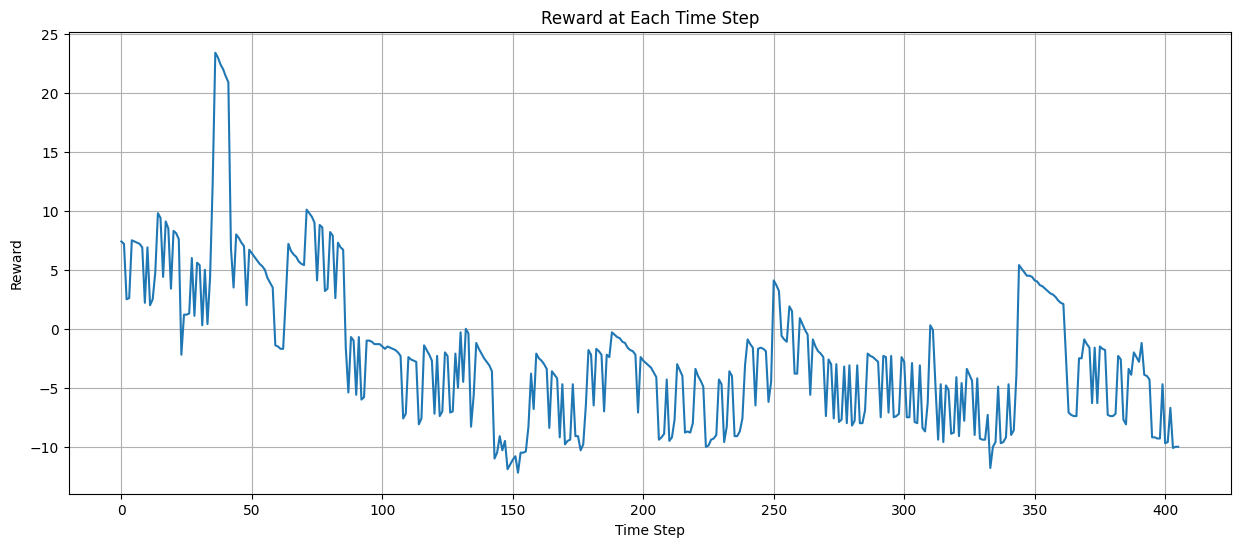

In [8]:
# Plot the rewards over time
plt.figure(figsize=(15, 6))
plt.plot(time_steps, rewards)
plt.title('Reward at Each Time Step')
plt.xlabel('Time Step')
plt.ylabel('Reward')
plt.grid(True)
plt.show()

In [12]:
# Sum up all rewards at the end of the simulation
total_reward = sum(rewards)
print(f"Total Reward: {total_reward}")

Total Reward: -873.7999999999996
